In [36]:
from datetime import datetime
import time

import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

import autosklearn.classification

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [37]:
df = pd.read_csv('../data/ordens_case_dnc_.csv', index_col='id')


In [38]:
df.head(2)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25+00:00,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59+00:00,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


Correção da data do campo "order_date"

In [39]:
df['order_date'] = df['order_date'].str[:-6]

In [40]:
df.head(2)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


Transformação de todas as datas para segundos

In [41]:
def getTimeSeconds(x):
    d = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return int(time.mktime(d.timetuple()))


df['order_date'] = df['order_date'].apply(getTimeSeconds)
df['due_date'] = df['due_date'].apply(getTimeSeconds)
df['opt_date'] = df['opt_date'].apply(getTimeSeconds)
df['delivery_date'] = df['delivery_date'].apply(getTimeSeconds)


In [42]:
len(df[df['opt_date'] < df['order_date']])


24

Remoção dos valores cujo a data de postagem é menor do que a data de compra

In [43]:
df = df[df['opt_date'] >= df['order_date']]


In [44]:
len(df[df['opt_date'] < df['order_date']])


0

Criação das colunas "post_time" (tempo de postagem) e "elapsed_time" (tempo de entrega)

In [45]:
df['post_time'] = df['opt_date'] - df['order_date']
df['elapsed_time'] = df['delivery_date'] - df['opt_date']


In [46]:
df.head(3)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,post_time,elapsed_time
id,,,,,,,,,,,,
0,107.78,1645832785,1646190000,1646091320,1646255013,2,1,25,1,23.8,258535,163693
1,7.47,1645659299,1645671600,1645707383,1645728760,2,1,16,4,536.0,48084,21377
3,5.98,1644514477,1645066800,1645094869,1645118592,2,1,21,1,441.0,580392,23723


Criação da coluna "outcome" (resultado da entrega. 1 = correta, 0 = atraso)

In [47]:
df['outcome'] = 0
df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
df['outcome'].value_counts()

1    1234
0     537
Name: outcome, dtype: int64

In [49]:
df.head(3)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,post_time,elapsed_time,outcome
id,,,,,,,,,,,,,
0,107.78,1645832785,1646190000,1646091320,1646255013,2,1,25,1,23.8,258535,163693,1
1,7.47,1645659299,1645671600,1645707383,1645728760,2,1,16,4,536.0,48084,21377,1
3,5.98,1644514477,1645066800,1645094869,1645118592,2,1,21,1,441.0,580392,23723,1


Conversão da tipagem de todas as variáveis categóricas para o tipo "category"

In [50]:
df["cidade_origem_id"] = df["cidade_origem_id"].astype("category")
df["regiao_origem_id"] = df["regiao_origem_id"].astype("category")
df["cidade_destino_id"] = df["cidade_destino_id"].astype("category")
df["regiao_destino_id"] = df["regiao_destino_id"].astype("category")


In [51]:
df.dtypes

price                 float64
order_date              int64
due_date                int64
opt_date                int64
delivery_date           int64
cidade_origem_id     category
regiao_origem_id     category
cidade_destino_id    category
regiao_destino_id    category
peso                  float64
post_time               int64
elapsed_time            int64
outcome                 int64
dtype: object

Plot de frequência de entregues atrasados ou não (indica que os dados precisam ser balanceados)

<AxesSubplot:ylabel='Frequency'>

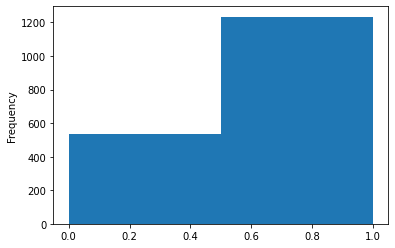

In [52]:
df['outcome'].plot.hist(bins=2)


Plot do gráfico de correlação entre variáveis preditoras (indica que algumas variáveis são extremamente correlacionadas)

<AxesSubplot:>

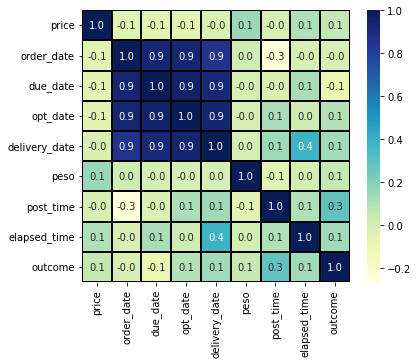

In [53]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


VIF (Verifica a significancia estatística das colunas. Maior ou igual a 5 indica menor significância)

In [54]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data

divide by zero encountered in double_scalars


,feature,VIF
0,price,1.139275
1,order_date,inf
2,due_date,21.946690
3,opt_date,inf
4,delivery_date,inf
5,cidade_origem_id,9.550134
6,regiao_origem_id,11.665396
7,cidade_destino_id,1.193633
8,regiao_destino_id,1.133119
9,peso,1.054088


Testes de hipótese

In [55]:
df.describe()

,price,order_date,due_date,opt_date,delivery_date,peso,post_time,elapsed_time,outcome
count,1771.000000,1.771000e+03,1.771000e+03,1.771000e+03,1.771000e+03,1771.000000,1.771000e+03,1.771000e+03,1771.000000
mean,9.254918,1.645379e+09,1.645569e+09,1.645514e+09,1.645611e+09,627.683202,1.351718e+05,9.611801e+04,0.696781
std,13.196693,4.351115e+05,4.309247e+05,4.223078e+05,4.559335e+05,2636.982411,1.640778e+05,1.622114e+05,0.459779
min,0.000000,1.643725e+09,1.644203e+09,1.644018e+09,1.644238e+09,0.000000,6.000000e+00,2.900000e+02,0.000000
25%,5.980000,1.645054e+09,1.645412e+09,1.645180e+09,1.645224e+09,0.365000,1.931050e+04,4.554300e+04,0.000000
50%,6.550000,1.645540e+09,1.645672e+09,1.645658e+09,1.645712e+09,1.250000,8.768200e+04,5.797800e+04,1.000000
75%,7.710000,1.645660e+09,1.646017e+09,1.645747e+09,1.645810e+09,332.500000,1.749065e+05,7.091300e+04,1.000000
max,200.280000,1.646009e+09,1.646708e+09,1.646925e+09,1.648747e+09,43832.000000,1.198821e+06,2.697347e+06,1.000000


Eliminação de variáveis altamente correlacionadas

In [21]:
df.drop(columns=['order_date', 'due_date', 'opt_date', 'delivery_date', 'regiao_origem_id',
        'regiao_destino_id'], inplace=True)


<AxesSubplot:>

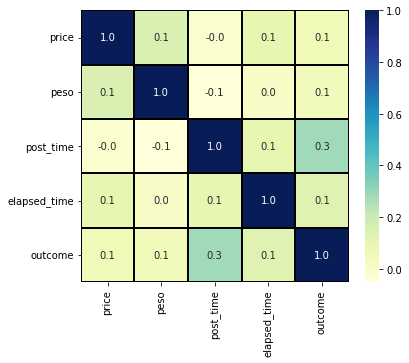

In [22]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


Significância estatistica do modelo revisada e corrigida

In [23]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data


,feature,VIF
0,price,1.446526
1,cidade_origem_id,3.203289
2,cidade_destino_id,2.085958
3,peso,1.090828
4,post_time,2.223420
5,elapsed_time,1.393292
6,outcome,2.869556


## Preprocessor

Dummyficação de variáveis categóricas

In [24]:
dummy_df = pd.get_dummies(df[['cidade_origem_id',
                          'cidade_destino_id']], drop_first=True)
df = df.join(dummy_df)
df.drop(columns=['cidade_origem_id', 'cidade_destino_id'], inplace=True)


In [25]:
df.head()

,price,peso,post_time,elapsed_time,outcome,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,cidade_destino_id_2,...,cidade_destino_id_118,cidade_destino_id_119,cidade_destino_id_120,cidade_destino_id_121,cidade_destino_id_122,cidade_destino_id_123,cidade_destino_id_124,cidade_destino_id_125,cidade_destino_id_126,cidade_destino_id_127
id,,,,,,,,,,,,,,,,,,,,,
0,107.78,23.80,258535,163693,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.47,536.00,48084,21377,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.98,441.00,580392,23723,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.37,0.73,39753,21553,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7.47,875.00,45465,26751,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Divisão do dataset em treino, validação e teste

In [26]:
X = df.drop(['outcome'], axis=1)
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x


Tratamento dos dados por dataset dividido (eliminação da possibilidade de vazamento de dados). Tratamentos:

1. Balanceamento de dados
2. Normalização de dados

In [27]:
def trataDados(df_dados, target):
    # Balanceamento dos dados
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    df_dados, target = sm.fit_resample(df_dados, target)

    # Normalização dos dados
    df_dados[['price', 'peso', 'post_time', 'elapsed_time']] = RobustScaler(
    ).fit_transform(df_dados[['price', 'peso', 'post_time', 'elapsed_time']]).copy()

    return df_dados, target


X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)


In [28]:
X_train.head()


,price,peso,post_time,elapsed_time,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,cidade_destino_id_2,cidade_destino_id_3,...,cidade_destino_id_118,cidade_destino_id_119,cidade_destino_id_120,cidade_destino_id_121,cidade_destino_id_122,cidade_destino_id_123,cidade_destino_id_124,cidade_destino_id_125,cidade_destino_id_126,cidade_destino_id_127
0,-0.575758,0.813647,-0.367710,0.453470,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.357576,-0.019408,-0.082900,-2.116727,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.357576,0.743955,-0.129859,-1.657634,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.575758,0.837887,0.202454,-0.286182,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.357576,-0.018923,1.878039,-1.290676,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## AutoML (testes)

In [134]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=20)


In [135]:
automl.fit(X_train, y_train)


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


AutoSklearnClassifier(per_run_time_limit=60, time_left_for_this_task=1200)

F1 Score: 89.4%
Accuracy Score: 89.47%
Precision Score: 83.74%
Recall Score: 97.98%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


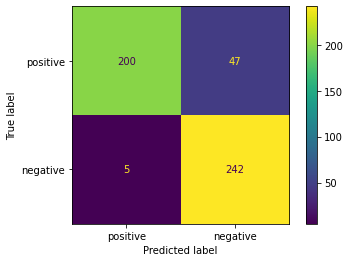

In [136]:
predictAutoML = automl.predict(X_val)

f1 = round(f1_score(y_val, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predictAutoML)*100, 2)
precision = round(precision_score(y_val, predictAutoML)*100, 2)
recall = round(recall_score(y_val, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_val, y_val, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()


F1 Score: 91.34%
Accuracy Score: 91.36%
Precision Score: 87.92%
Recall Score: 95.88%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


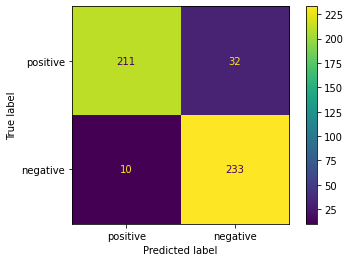

In [137]:
predictAutoML = automl.predict(X_test)

f1 = round(f1_score(y_test, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictAutoML)*100, 2)
precision = round(precision_score(y_test, predictAutoML)*100, 2)
recall = round(recall_score(y_test, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_test, y_test, display_labels=[
                      "positive", "negative"], values_format="d")
plt.grid(False)
plt.show()


In [138]:
pd.DataFrame(automl.show_models()).transpose()


,model_id,rank,cost,ensemble_weight,data_preprocessor,balancing,feature_preprocessor,classifier,sklearn_classifier
2,2,1,0.067073,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=10, rando..."
113,113,2,0.067073,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=9, min_sa..."
25,25,3,0.069106,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=8, min_sa..."
80,80,4,0.073171,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=4, min_sa..."
127,127,5,0.073171,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=2, min_sa..."
101,101,6,0.075203,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=9, min_sa..."
124,124,7,0.075203,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=3, min_sa..."
103,103,8,0.077236,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
128,128,9,0.077236,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=7, min_sa..."
104,104,10,0.079268,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=4, min_sa..."


## Modeling

### Decision Tree

Treino

In [139]:
dtc_model = DecisionTreeClassifier(
    max_depth=75, max_leaf_nodes=50, min_samples_leaf=5, min_samples_split=5)
dtc_model.fit(X_train, y_train)


DecisionTreeClassifier()

Validação (padrão)

F1 Score: 70.11%
Accuracy Score: 70.45%
Precision Score: 66.89%
Recall Score: 80.97%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


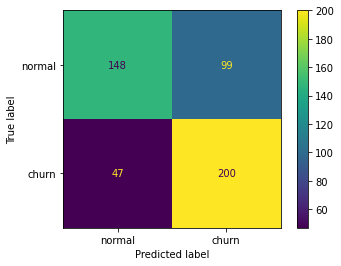

In [140]:
predict_DTC = dtc_model.predict(X_val)

f1 = round(f1_score(y_val, predict_DTC, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_DTC)*100, 2)
precision = round(precision_score(y_val, predict_DTC)*100, 2)
recall = round(recall_score(y_val, predict_DTC)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(dtc_model, X_val, y_val, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()


Validação (tunning)

In [ ]:
# parameters = {
#     "criterion": ['gini', 'entropy'],
#     "max_depth": [25, 50, 75, 100, None],
#     "min_samples_split": [2, 5, 10, 50, 100, 250],
#     "min_samples_leaf": [5, 10, 25, 50, 100],
#     "max_leaf_nodes": [5, 10, 15, 25, 50]
# }

# TreeGrid = GridSearchCV(DecisionTreeClassifier(),
#                         parameters, scoring='f1', verbose=True)
# TreeGridModel = TreeGrid.fit(X_train, y_train)

# Saída: DecisionTreeClassifier(max_depth=75, max_leaf_nodes=50, min_samples_leaf=5, min_samples_split = 5)


In [ ]:
dtc_model = DecisionTreeClassifier(criterion='gini', max_depth=75, max_leaf_nodes=50, min_samples_leaf=5, min_samples_split=5)
dtc_model.fit(X_train, y_train)

In [ ]:
predict_DTC = dtc_model.predict(X_test)

f1 = round(f1_score(y_test, predict_DTC, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predict_DTC)*100, 2)
precision = round(precision_score(y_test, predict_DTC)*100, 2)
recall = round(recall_score(y_test, predict_DTC)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(dtc_model, X_test, y_test, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()

Teste

F1 Score: 70.11%
Accuracy Score: 70.45%
Precision Score: 66.89%
Recall Score: 80.97%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


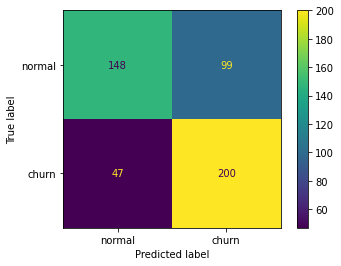

In [141]:
predict_DTC = dtc_model.predict(X_val)

f1 = round(f1_score(y_val, predict_DTC, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_DTC)*100, 2)
precision = round(precision_score(y_val, predict_DTC)*100, 2)
recall = round(recall_score(y_val, predict_DTC)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(dtc_model, X_val, y_val, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()


### KNN

Treino

In [142]:
knn_model = KNeighborsRegressor(3)
knn_model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=3)

Validação (tunning de hyperparâmetros)

In [143]:
predict_KNN = knn_model.predict(X_val)

mse = mean_squared_error(y_val, predict_KNN)
rmse = sqrt(mse)
rmse


0.3959420796711825

Teste

In [144]:
predict_KNN = knn_model.predict(X_test)

mse = mean_squared_error(y_test, predict_KNN)
rmse = sqrt(mse)
rmse


0.3960250600579121

### Multilayer Perceptron

Treino

In [29]:
mlp_model = MLPClassifier(hidden_layer_sizes=(6, 5),
                          random_state=5,
                          verbose=True,
                          learning_rate_init=0.01)
mlp_model.fit(X_train, y_train)


Iteration 1, loss = 0.76328932
Iteration 2, loss = 0.68759241
Iteration 3, loss = 0.62817993
Iteration 4, loss = 0.56776720
Iteration 5, loss = 0.50208409
Iteration 6, loss = 0.43691446
Iteration 7, loss = 0.37873297
Iteration 8, loss = 0.33324212
Iteration 9, loss = 0.29702362
Iteration 10, loss = 0.27274753
Iteration 11, loss = 0.24133239
Iteration 12, loss = 0.23052286
Iteration 13, loss = 0.21978470
Iteration 14, loss = 0.20312601
Iteration 15, loss = 0.20090891
Iteration 16, loss = 0.18956340
Iteration 17, loss = 0.17968180
Iteration 18, loss = 0.17498068
Iteration 19, loss = 0.16221677
Iteration 20, loss = 0.16314386
Iteration 21, loss = 0.15989178
Iteration 22, loss = 0.15408499
Iteration 23, loss = 0.14902530
Iteration 24, loss = 0.14580099
Iteration 25, loss = 0.14569730
Iteration 26, loss = 0.14752963
Iteration 27, loss = 0.14321453
Iteration 28, loss = 0.13985072
Iteration 29, loss = 0.13687594
Iteration 30, loss = 0.13507463
Iteration 31, loss = 0.13469569
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(6, 5), learning_rate_init=0.01,
              random_state=5, verbose=True)

Validação (padrão)

F1 Score: 90.27%
Accuracy Score: 90.28%
Precision Score: 87.55%
Recall Score: 93.93%


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


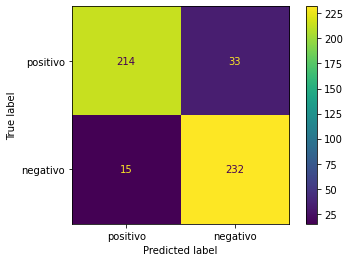

In [35]:
predict_MLP = mlp_model.predict(X_val)

f1 = round(f1_score(y_val, predict_MLP, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_MLP)*100, 2)
precision = round(precision_score(y_val, predict_MLP)*100, 2)
recall = round(recall_score(y_val, predict_MLP)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(mlp_model, X_val, y_val, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()

Validação (tunning)

In [ ]:
# parameters = {
#     "hidden_layer_sizes": [(100,), (200,)],
#     "activation": ['identity', 'relu', 'tahn'],
#     "solver": ['sgd', 'adam', ]
# }

# MLPGrid = GridSearchCV(MLPClassifier(), parameters, scoring='f1', verbose=True)
# MLPGridModel = MLPGrid.fit(X_train, y_train)

# Saída: MLPClassifier(hidden_layer_sizes=(200,), random_state=5, activation='relu', solver='adam', verbose=True, learning_rate_init=0.01)

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(200,),
                          random_state=5,
                          activation='relu',
                          solver='adam',
                          verbose=True,
                          learning_rate_init=0.01)
mlp_model.fit(X_train, y_train)

In [ ]:
predict_MLP = mlp_model.predict(X_test)

f1 = round(f1_score(y_test, predict_MLP, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predict_MLP)*100, 2)
precision = round(precision_score(y_test, predict_MLP)*100, 2)
recall = round(recall_score(y_test, predict_MLP)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()


Teste

F1 Score: 91.77%
Accuracy Score: 91.77%
Precision Score: 92.12%
Recall Score: 91.36%


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


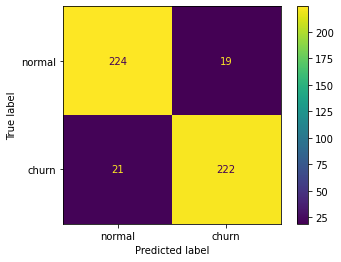

In [31]:
predict_MLP = mlp_model.predict(X_test)

f1 = round(f1_score(y_test, predict_MLP, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predict_MLP)*100, 2)
precision = round(precision_score(y_test, predict_MLP)*100, 2)
recall = round(recall_score(y_test, predict_MLP)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=[
                      "positivo", "negativo"], values_format="d")
plt.grid(False)
plt.show()
